In [1]:
from zurich_move_data_extraction import *
from activity_count_function import *
from utilities import *
from gm_function import *
from individual_analysis_ac_functions import *
from extract_mask_from_video import *
from individual_analysis_fs_functions import *
from group_analysis_functions import *

C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#CHANGE VALUES HERE#
# H for Healthy and S for Stroke 
participant_id = 'S003'
participant_group = 'S'

In [3]:
#PATH 
initial_path = '../CreateStudy'
participant_path = os.path.join(initial_path, participant_id)
print(participant_path)

../CreateStudy\S003


In [4]:
# Extract dataset from the participant JSON file 
participant_data = load_participant_json(participant_id, initial_path)
# Get the correct handiness 
# For stroke, dominant hand = non affected hand 
dominant_hand = get_dominant_hand(participant_data)

In [5]:
# Get the data from IMU csv files 
ndh_data, chest_data, dh_data, GT_mask_25Hz_NDH, GT_mask_25Hz_DH = get_data(participant_path, dominant_hand)
# Ensure the array sizes consistency between masks and IMU data
print (len(GT_mask_25Hz_NDH)*2, len(ndh_data))

70080 70080


In [6]:
# Get useful variables
sampling_freq = 50
acc_ndh = ndh_data[['acc_x', 'acc_y', 'acc_z']]
acc_dh = dh_data[['acc_x', 'acc_y', 'acc_z']]
gyro_ndh = ndh_data[['gyro_x', 'gyro_y', 'gyro_z']]
gyro_dh = dh_data[['gyro_x', 'gyro_y', 'gyro_z']]
mag_ndh = ndh_data[['magneto_x', 'magneto_y', 'magneto_z']]
quat_sensor_ndh = ndh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
quat_sensor_dh = dh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
frequency_AC = 1 # Hz 
frequency_GM = 2 # Hz
FPS_mask = 25 # Hz
frequency_euler_angles = 50 # Hz 

In [7]:
#Compute Actigraph Activity Count 
count_brond_ndh, processed_data_ndh = get_counts_brond(ndh_data)
count_brond_dh, processed_data_dh = get_counts_brond(dh_data)
AC_ndh = np.array(count_brond_ndh['AC Brond'])
AC_dh = np.array(count_brond_dh['AC Brond'])

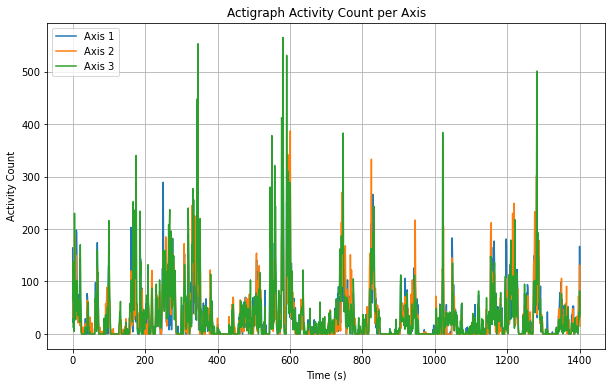

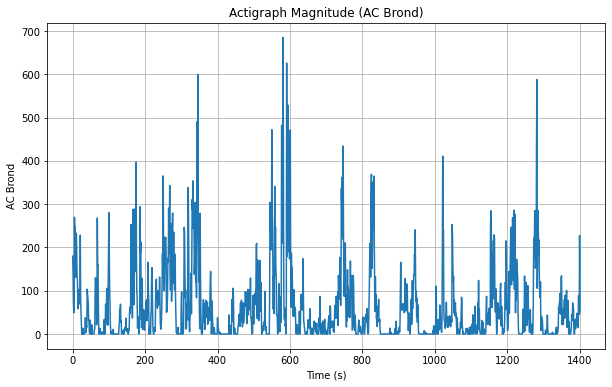

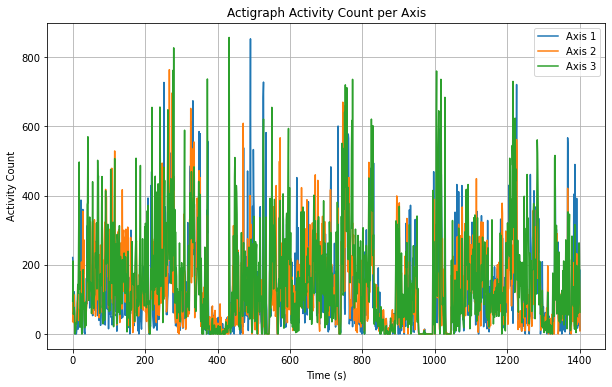

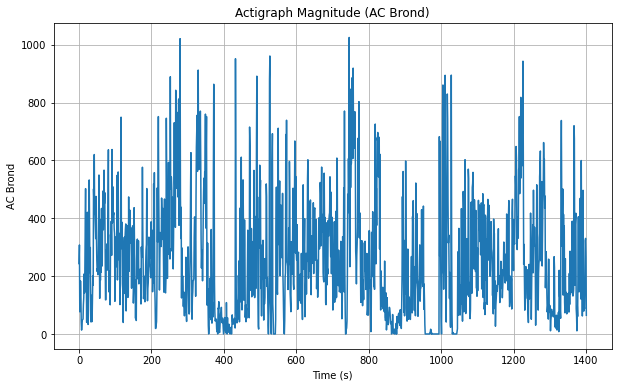

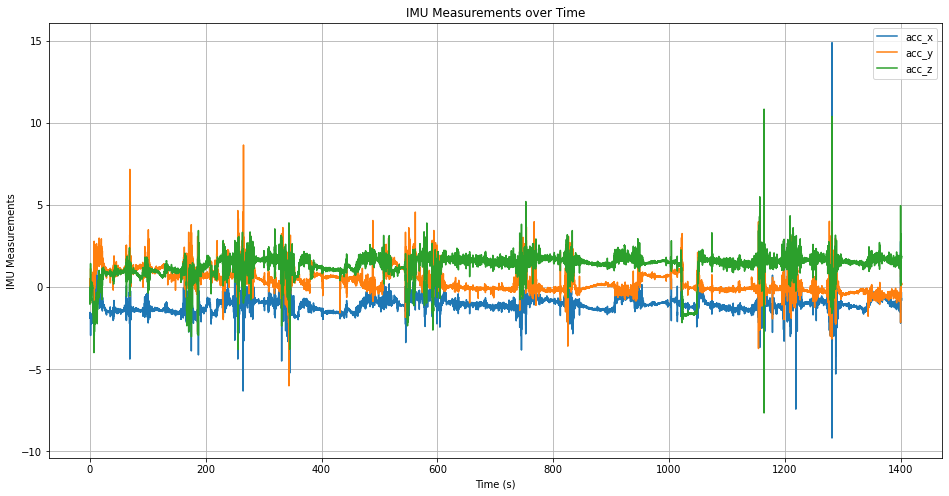

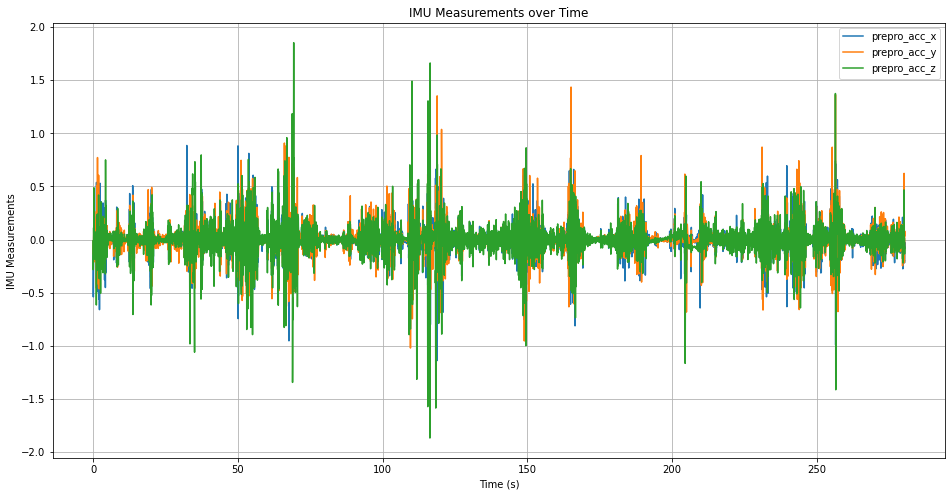

In [8]:
plot_actigraph_count(count_brond_ndh), plot_actigraph_count(count_brond_dh)
plot_raw_data(acc_ndh, sampling_freq)
plot_raw_data(processed_data_ndh, sampling_freq)

In [9]:
# MASK #

In [10]:
# Replace all WBM by NF movements inside the GT mask @ 25 Hz 
GT_mask_25Hz_NDH = replace_wbm_with_nf(GT_mask_25Hz_NDH).ravel()
GT_mask_25Hz_DH = replace_wbm_with_nf(GT_mask_25Hz_DH).ravel()

In [11]:
# Downsample GT masks to be used later on for AC (1Hz) and GM (2Hz) computation
GT_mask_NDH_1Hz = resample_mask(GT_mask_25Hz_NDH, FPS_mask, frequency_AC)
GT_mask_DH_1Hz = resample_mask(GT_mask_25Hz_DH, FPS_mask, frequency_AC)
GT_mask_NDH_2Hz = resample_mask(GT_mask_25Hz_NDH, FPS_mask, frequency_GM)
GT_mask_DH_2Hz = resample_mask(GT_mask_25Hz_DH, FPS_mask, frequency_GM)

# Ensure GT Mask @ 1 hZ have same size as the Brond AC values 
GT_mask_NDH_1Hz, AC_ndh = remove_extra_elements(GT_mask_NDH_1Hz, AC_ndh)
GT_mask_DH_1Hz, AC_dh = remove_extra_elements(GT_mask_DH_1Hz, AC_dh)

In [12]:
# Upsample GT masks to be used lated for the GM algorithm computation (50 Hz)
GT_mask_NDH_50Hz = resample_mask(GT_mask_25Hz_NDH, FPS_mask, frequency_euler_angles)
GT_mask_DH_50Hz = resample_mask(GT_mask_25Hz_DH, FPS_mask, frequency_euler_angles)

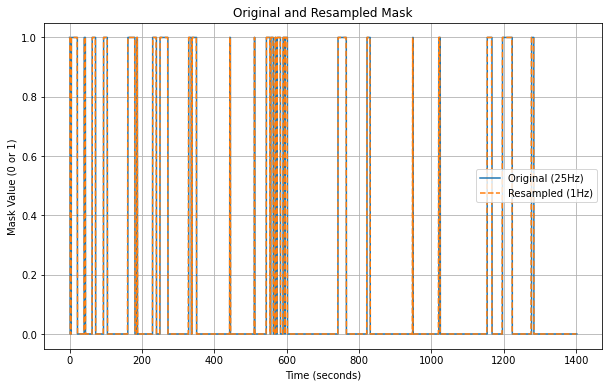

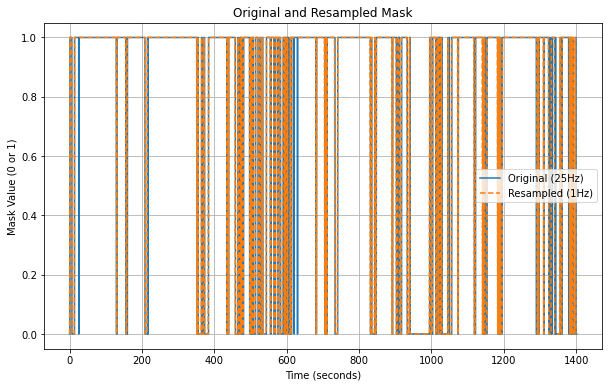

In [13]:
# Some plots to ensure the downsampling was correctly done
plot_resampled_arrays(GT_mask_25Hz_NDH, FPS_mask, GT_mask_NDH_1Hz, frequency_AC)
plot_resampled_arrays(GT_mask_25Hz_DH, FPS_mask, GT_mask_DH_1Hz, frequency_AC)

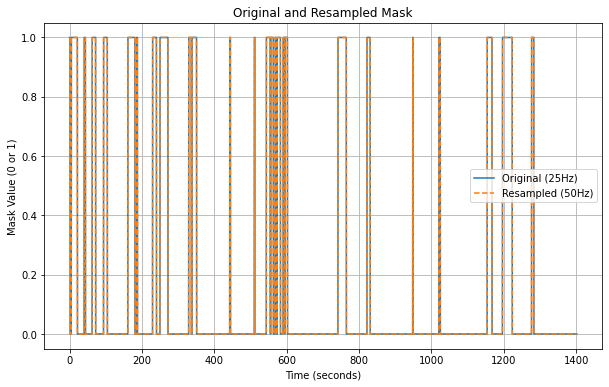

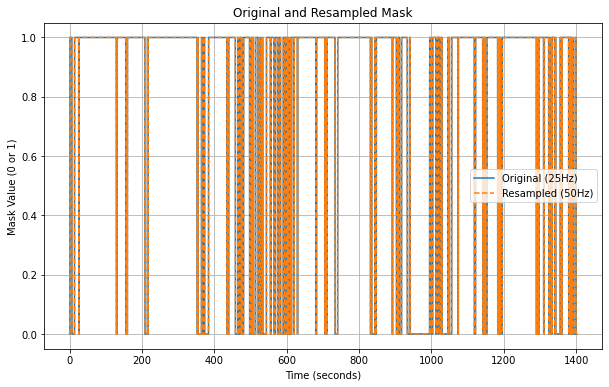

In [14]:
# Some plots to ensure the upsampling was correctly done
plot_resampled_arrays(GT_mask_25Hz_NDH, FPS_mask, GT_mask_NDH_50Hz, frequency_euler_angles)
plot_resampled_arrays(GT_mask_25Hz_DH, FPS_mask, GT_mask_DH_50Hz, frequency_euler_angles)

In [15]:
# Update the participant JSON file with new arrays of usefull data  
# Add Brond AC 
add_attributes_to_participant(participant_data, AC_NDH = AC_ndh, AC_DH = AC_dh)
# Add mask @ 1 Hz, @ 2 Hz and @ 50 Hz
add_attributes_to_participant(participant_data, GT_mask_NDH_1Hz = GT_mask_NDH_1Hz, GT_mask_DH_1Hz = GT_mask_DH_1Hz, 
                             GT_mask_NDH_2Hz = GT_mask_NDH_2Hz, GT_mask_DH_2Hz = GT_mask_DH_2Hz, 
                             GT_mask_NDH_50Hz = GT_mask_NDH_50Hz, GT_mask_DH_50Hz = GT_mask_DH_50Hz)

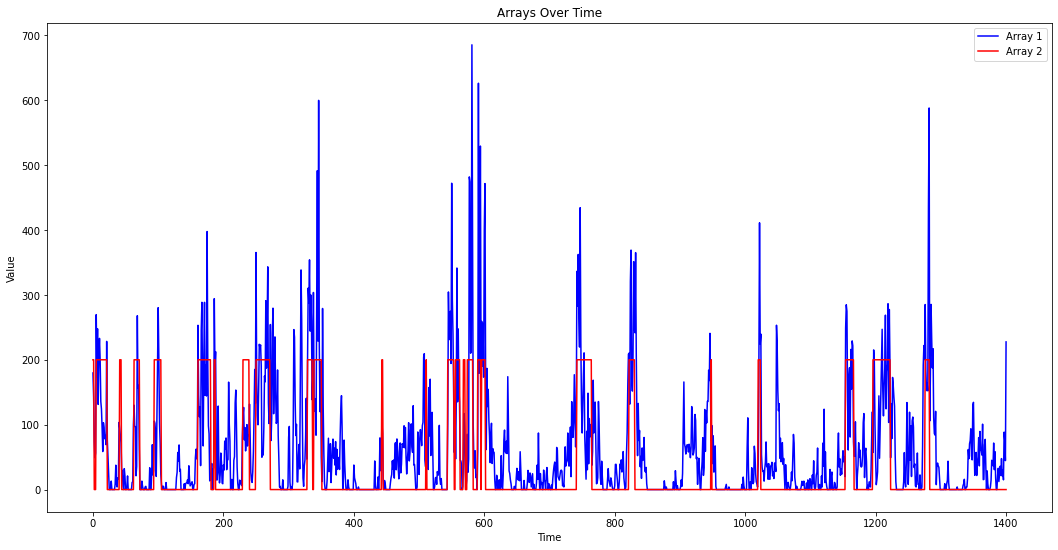

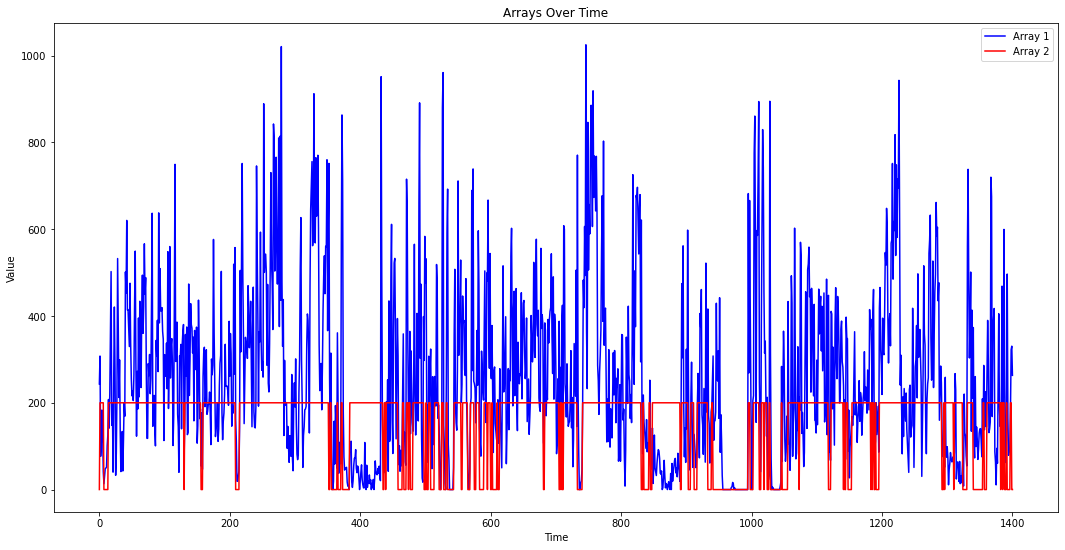

In [16]:
plot_superposition(AC_ndh, 200*GT_mask_NDH_1Hz)
plot_superposition(AC_dh, 200*GT_mask_DH_1Hz)

In [17]:
# Perform k-fold cross-validation for the left wrist data
# Optimal: Return average optimal AC threshold and average evaluation metrics 
eval_metrics_opt_ndh, opt_threshold_ndh = k_fold_cross_validation(AC_ndh, GT_mask_NDH_1Hz, optimal=True)
# Conventional: Return conventional AC threshold and average evaluation metrics 
eval_metrics_conv_ndh, conv_threshold_ndh = k_fold_cross_validation(AC_ndh, GT_mask_NDH_1Hz, optimal=False)

Iteration 1/5
AUC: 0.9177915276310566
Optimal Threshold: 80.54
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 2/5
AUC: 0.904945992974162
Optimal Threshold: 71.85
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 3/5
AUC: 0.9136761366782964
Optimal Threshold: 66.83
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 4/5
AUC: 0.9171695542145222
Optimal Threshold: 80.54
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 5/5
AUC: 0.9075829254733537
Optimal Threshold: 74.05
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 1/5
Using conventional threshold
Iteration 2/5
Using conventional threshold
Iteration 3/5
Using conventional threshold
Iteration 4/5
Using conventional threshold
Iteration 5/5
Using conventional threshold


In [18]:
# Perform k-fold cross-validation for the right wrist data
# Optimal: Return average optimal AC threshold and average evaluation metrics 
eval_metrics_opt_dh, opt_threshold_dh = k_fold_cross_validation(AC_dh, GT_mask_DH_1Hz, optimal=True)
# Conventional: Return conventional AC threshold and average evaluation metrics 
eval_metrics_conv_dh, conv_threshold_dh = k_fold_cross_validation(AC_dh, GT_mask_DH_1Hz, optimal=False)

Iteration 1/5
AUC: 0.7865204410151262
Optimal Threshold: 172.62
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 2/5
AUC: 0.7871080139372822
Optimal Threshold: 180.13
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 3/5
AUC: 0.7737760207272404
Optimal Threshold: 180.13
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 4/5
AUC: 0.7880401152717371
Optimal Threshold: 180.13
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 5/5
AUC: 0.7935892362485161
Optimal Threshold: 180.13
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)
Iteration 1/5
Using conventional threshold
Iteration 2/5
Using conventional threshold
Iteration 3/5
Using conventional threshold
Iteration 4/5
Using conventional threshold
Iteration 5/5
Using conventional threshold


In [19]:
# Bilaterage usage of the UL
eval_metrics_opt_bil = k_fold_cross_validation_bilateral(AC_ndh, AC_dh, GT_mask_NDH_1Hz,
                                                         GT_mask_DH_1Hz, opt_threshold_ndh,
                                                         opt_threshold_dh, optimal=True)
eval_metrics_conv_bil = k_fold_cross_validation_bilateral(AC_ndh, AC_dh, GT_mask_NDH_1Hz,
                                                          GT_mask_DH_1Hz, opt_threshold_ndh,
                                                          opt_threshold_dh, optimal=False)

Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5
Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5


In [20]:
# Optimal AC thresholds for this participant 
print(opt_threshold_ndh, opt_threshold_dh)

74.76 178.63


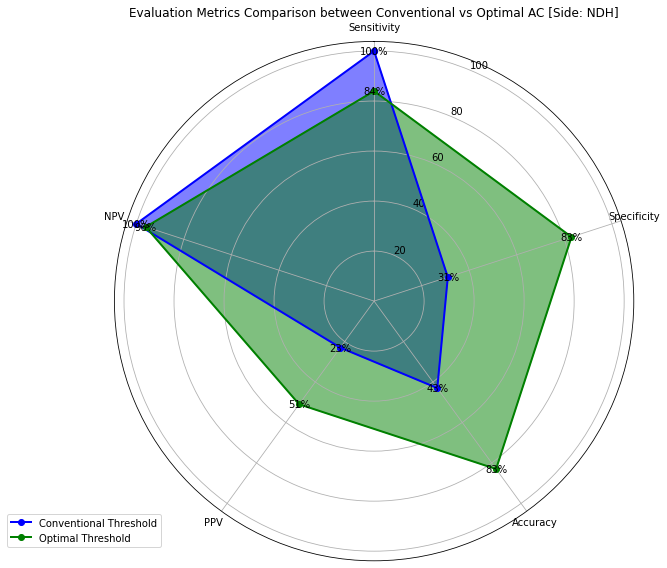

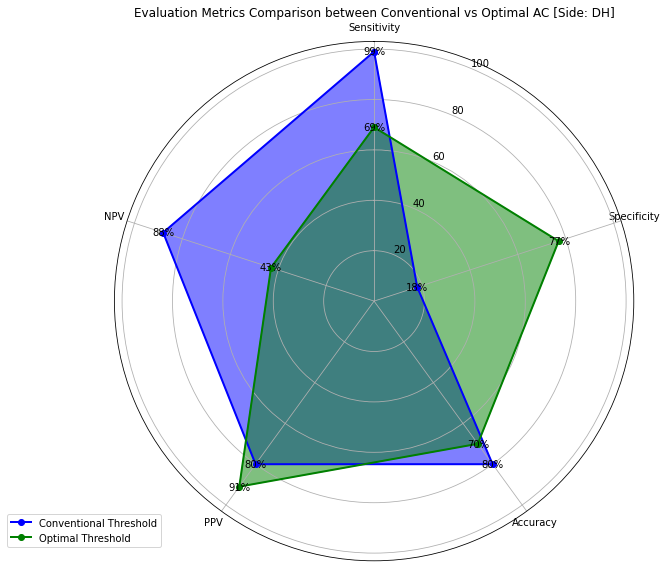

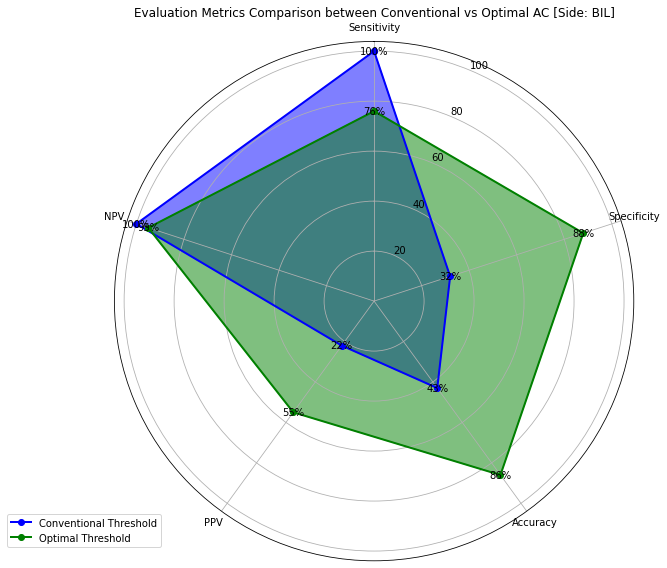

In [21]:
plot_radar_chart(eval_metrics_conv_ndh, eval_metrics_opt_ndh, metric = "AC", scenario = 'ndh')
plot_radar_chart(eval_metrics_conv_dh, eval_metrics_opt_dh, metric = "AC",scenario = 'dh')
plot_radar_chart(eval_metrics_conv_bil, eval_metrics_opt_bil, metric = "AC", scenario = 'bil')

In [22]:
# Create a structure to save all the metrics 
metrics_dictionary_AC = create_metrics_dictionary(eval_metrics_conv_ndh, eval_metrics_conv_dh,
                                               eval_metrics_conv_bil, eval_metrics_opt_ndh,
                                               eval_metrics_opt_dh, eval_metrics_opt_bil)

In [23]:
metrics_dictionary_AC

{'OT_ndh_Sensitivity': 84.37647907647907,
 'OT_ndh_Specificity': 83.2620723811548,
 'OT_ndh_Accuracy': 83.36959837315709,
 'OT_ndh_PPV': 51.3614901300931,
 'OT_ndh_NPV': 96.15312134247515,
 'OT_dh_Sensitivity': 68.53663265860123,
 'OT_dh_Specificity': 76.72386126253639,
 'OT_dh_Accuracy': 70.44890696492119,
 'OT_dh_PPV': 90.70039231208338,
 'OT_dh_NPV': 42.6282472871913,
 'OT_bilateral_Sensitivity': 75.83884036620015,
 'OT_bilateral_Specificity': 88.16814698964262,
 'OT_bilateral_Accuracy': 86.15378749364514,
 'OT_bilateral_PPV': 55.11582745207171,
 'OT_bilateral_NPV': 94.95479388514664,
 'CT_ndh_Sensitivity': 100.0,
 'CT_ndh_Specificity': 31.33370161792479,
 'CT_ndh_Accuracy': 43.25419420437214,
 'CT_ndh_PPV': 23.438709672082275,
 'CT_ndh_NPV': 100.0,
 'CT_dh_Sensitivity': 99.26000545918018,
 'CT_dh_Specificity': 17.960136526747515,
 'CT_dh_Accuracy': 80.30045754956788,
 'CT_dh_PPV': 79.91367954789058,
 'CT_dh_NPV': 87.78225695872754,
 'CT_bilateral_Sensitivity': 100.0,
 'CT_bilateral

In [24]:
# Add metrics for AC threshold evaluation to the JSON file 
add_attributes_to_participant(participant_data, metrics_dictionary_AC = metrics_dictionary_AC) 
# Add optimal AC parameter to the JSON file 
add_attributes_to_participant(participant_data, optimal_AC_NDH = opt_threshold_ndh, optimal_AC_DH = opt_threshold_dh) 

In [25]:
# Laterality metrics # 

In [26]:
# Bilateral Magnitude 
bilateral_magnitude = compute_bilateral_magnitude(AC_ndh, AC_dh)

In [27]:
magnitude_ratio = get_magnitude_ratio(AC_ndh, AC_dh)

Figure saved as '../CreateStudy\S003\ratio_distribution.png'


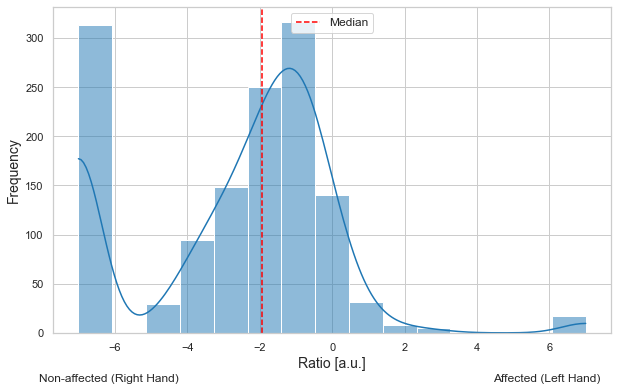

Figure saved as '../CreateStudy\S003\density_plot.png'


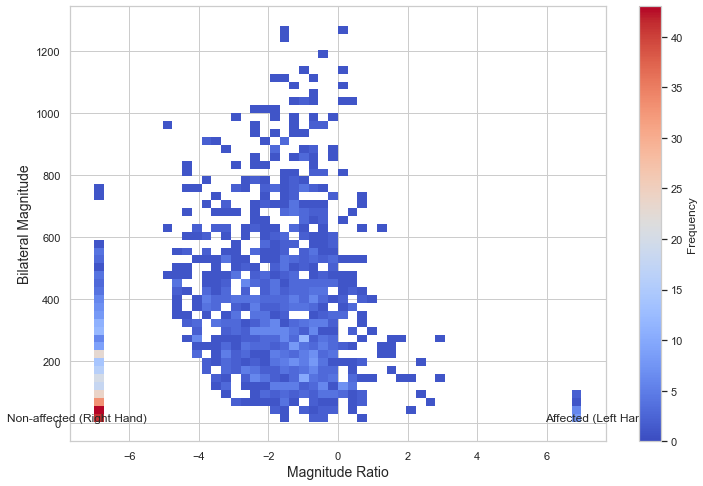

In [28]:
plot_distribution_ratio(magnitude_ratio, non_affected_hand = dominant_hand, saving_path = participant_path)
plot_density(bilateral_magnitude, magnitude_ratio, non_affected_hand = dominant_hand, saving_path = participant_path)

In [29]:
# Save the JSON file with the new fields 
save_to_json(participant_data, participant_path)

Data saved to: ../CreateStudy\S003\S003.json
